## Lab 04

Due date: Thursday, **Feb 20** submitted as PDF or HTML to Canvas Lab04 link. This lab counts 9 % toward your total grade.

Objectives:
1. Understand Spatial Relationships.
2. Implement Subqueries.

For each task:
1. Provide the SQL Query 
2. Plot the output. 


In [2]:
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy import text
import os
import geopandas as gpd

In [3]:
host = 'localhost'
database = 'spatialdata'
user = 'postgres'
port = '5432'
password = os.getenv('SQL_PASSWORD')

In [4]:
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

In [5]:
engine = create_engine(connection_string)
insp = inspect(engine)
insp.get_table_names()

['spatial_ref_sys', 'nyc_census_blocks_2000', 'nyc_subway_stations']

## Task 1

Select subway stations with the colors RED and GREY, then plot them in two different colors on the map.

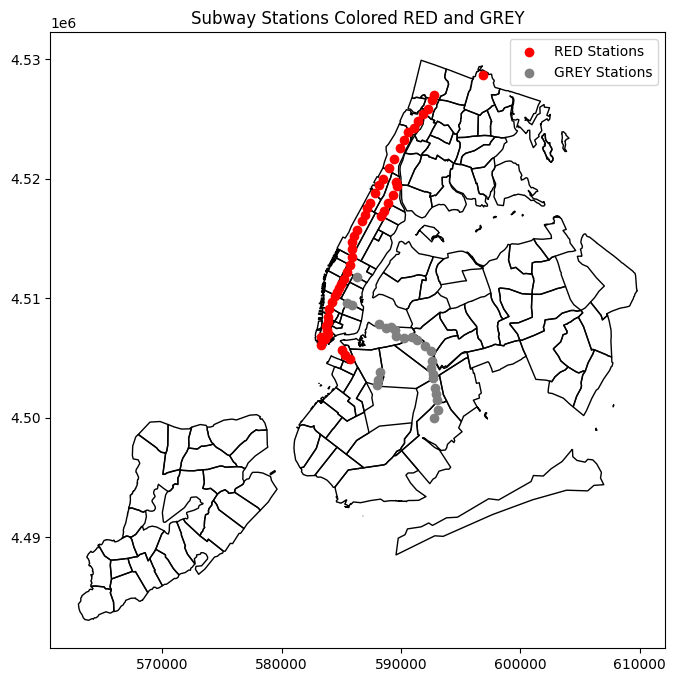

In [6]:
query = """
SELECT name, color, geom
FROM ch05.subway
WHERE color IN ('RED', 'GREY');
"""

subway_stations = gpd.read_postgis(query, engine, geom_col='geom')

query02 = """
SELECT * FROM ch05.neighborhoods
"""

all_neighborhood = gpd.read_postgis(query02, engine, geom_col='geom')
# Plotting with different colors for RED and GREY stations
fig, ax = plt.subplots(figsize=(10, 8))
all_neighborhood.plot(ax=ax, color = 'none')
subway_stations[subway_stations['color'] == 'RED'].plot(ax=ax, color='red', label='RED Stations')
subway_stations[subway_stations['color'] == 'GREY'].plot(ax=ax, color='grey', label='GREY Stations')

plt.legend()
plt.title('Subway Stations Colored RED and GREY')
plt.show()

## Task 2: ST_Crosses

Using [ST_Crosses](https://postgis.net/docs/ST_Crosses.html) to identify the streets that **cross** with the 100 m buffer around each station.

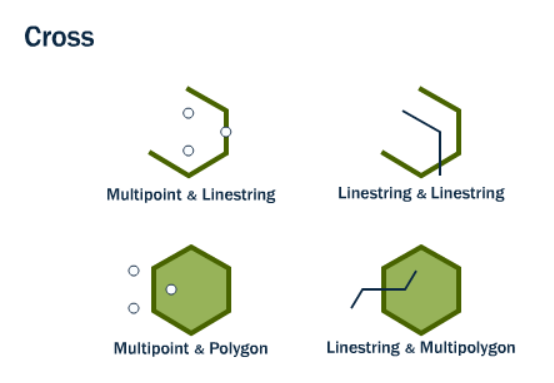

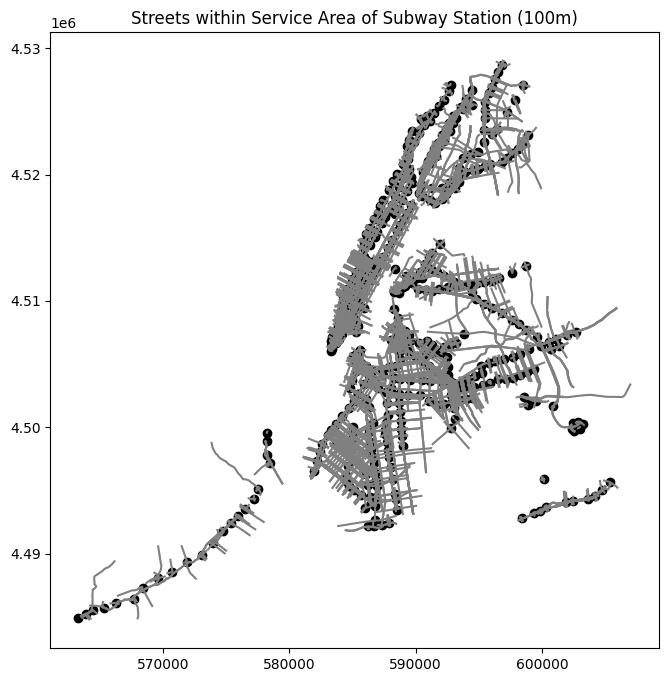

In [7]:
query = """
SELECT subway.name, street.geom
FROM ch05.subway subway, ch05.streets street
WHERE ST_Crosses(ST_Buffer(subway.geom, 100), street.geom);
"""

all_subway_query = """ SELECT * FROM ch05.subway
"""
overlapping_service_areas = gpd.read_postgis(query, engine, geom_col='geom')
all_subway = gpd.read_postgis(all_subway_query, engine, geom_col='geom')
# Plotting service areas with no fill color to highlight overlaps
fig, ax = plt.subplots(figsize=(10, 8))

all_subway.plot(ax = ax, color = 'black')
overlapping_service_areas.plot(ax=ax, facecolor='none', edgecolor='grey')

plt.title('Streets within Service Area of Subway Station (100m)')
plt.show()

## Task 3: ST_Centroid

Calculate the centroid of each neighborhood polygon using [ST_Centroid](https://postgis.net/docs/ST_Centroid.html) and visualize them on the map.

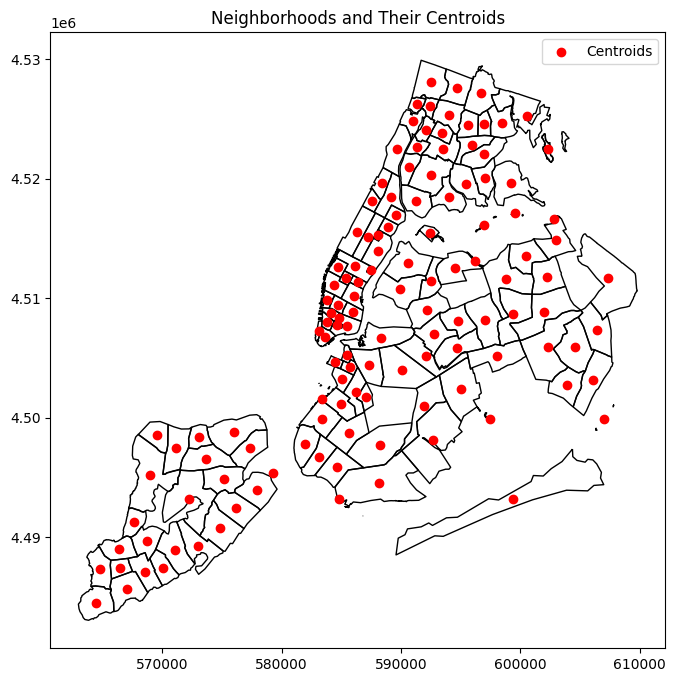

In [11]:
query = """
SELECT name, ST_Centroid(geom) AS geom
FROM ch05.neighborhoods;
"""

neighborhood_centroids = gpd.read_postgis(query, engine, geom_col='geom')

# Plot neighborhoods and their centroids
neighborhoods = gpd.read_postgis("SELECT * FROM ch05.neighborhoods", engine, geom_col='geom')

fig, ax = plt.subplots(figsize=(10, 8))
neighborhoods.plot(ax=ax, edgecolor='black', facecolor='none')
neighborhood_centroids.plot(ax=ax, color='red', marker='o', label='Centroids')

plt.legend()
plt.title('Neighborhoods and Their Centroids')
plt.show()

## Task 4. Nearest subway station to each centroid

Use these centroids to find the subway station closest to each neighborhood center.

[ST_Centroid](https://postgis.net/docs/ST_Centroid.html)

[ST_Distance](https://postgis.net/docs/ST_Distance.html)

MIN(ST_Distance()): The subquery is looking for the minimum distance between the neighborhood's centroid and all subway stations. 

<Axes: >

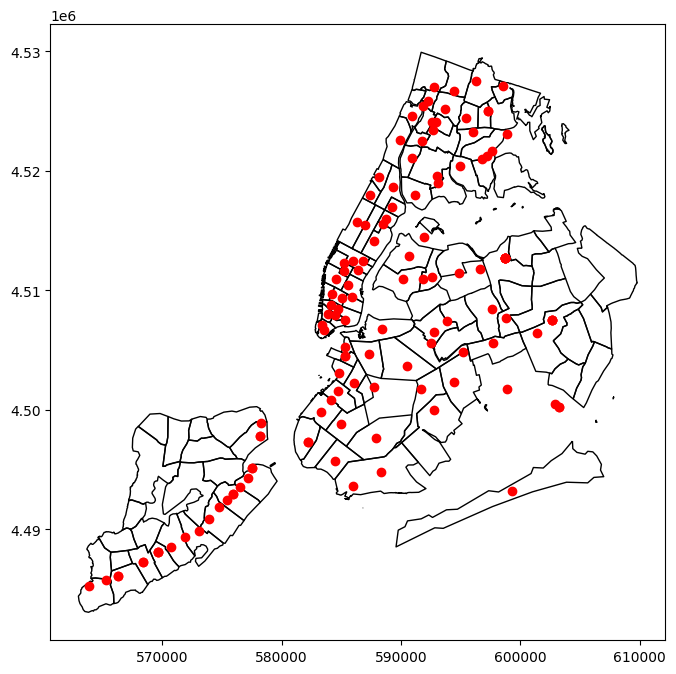

In [19]:
query = """SELECT nbh.name AS neighborhood, subway.name AS nearest_station, subway.geom
FROM ch05.neighborhoods AS nbh, ch05.subway AS subway
WHERE ST_Distance(ST_Centroid(nbh.geom), subway.geom) = (
    SELECT MIN(ST_Distance(ST_Centroid(nbh.geom), s.geom))
    FROM ch05.subway AS s
);"""

neighborhoods = gpd.read_postgis("SELECT * FROM ch05.neighborhoods", engine, geom_col='geom')
nearest_subway = gpd.read_postgis(query, engine)


fig, ax = plt.subplots(figsize=(10, 8))
neighborhoods.plot(ax=ax, edgecolor='black', facecolor='none')
nearest_subway.plot(ax=ax, color='red', marker='o', label='Centroids')
